<a href="https://colab.research.google.com/github/a1icia-m/misc-small-projects/blob/main/nlp/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
import pandas as pd

In [4]:
true = pd.read_csv("/content/True.csv")
fake = pd.read_csv("/content/Fake.csv", lineterminator='\n')

In [54]:
#Create labels for True or False
true['category'] = 1
fake['category'] = 0

#Combine datasets
news = pd.concat([true, fake], axis = 0)

#CLean and standardize date data across datasets
news['dates'] = news['date'].fillna(news['date\r'])
news['dates'] = news['dates'].str.replace('\r', '', regex=False)
news['dates'] = pd.to_datetime(news['dates'], format='mixed', errors='coerce')
news = news.drop(['date', 'date\r'], axis=1) #use = as .drop() returns new df with dropped cols
news.head()

,title,text,subject,label,category,dates
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,1,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,1,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,1,2017-12-31
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,1,2017-12-30
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,1,2017-12-29


In [37]:
news['category'].value_counts()

,count
category,
0,23481
1,21417


In [44]:
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
tokenizer = nltk.RegexpTokenizer(r"\w+")
stop_words = stopwords.words('english')





[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
#Preprocessing function to tokenize, remove stopwords, and lemmatize
def process(text):
  tokenized= tokenizer.tokenize(text)
  tokenized_no_stop = [x for x in tokenized if x not in stop_words]
  lowercase = [x.lower() for x in tokenized_no_stop]
  lemmatized_tokens = [lemmatizer.lemmatize(x) for x in lowercase]
  return (lemmatized_tokens)


test= "ABC peepeepoopooo it the so and chicken nugget!*(#& (*)) 123 testing test message"
tokenized_test = process(test)
print(tokenized_test)

['abc', 'peepeepoopooo', 'chicken', 'nugget', '123', 'testing', 'test', 'message']


In [56]:
#Shuffle then split dataset for training and testing
df = news.sample(frac = 1, random_state =1)

#Train on first 80%
split_index = int(len(df)*.8)
train_df, test_df = df[:split_index], df[split_index:]

train_df = train_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

train_df, test_df

(                                                   title  \
 0      EPA chief says Paris climate agreement 'bad de...   
 1      BREAKING NEWS: President Trump Announces Major...   
 2      Trump says New Hampshire win not necessary to ...   
 3      Kremlin: U.S. sanctions aimed at turning busin...   
 4      MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...   
 ...                                                  ...   
 35913  DELUSIONAL DEMOCRAT AL GREEN: “I Will Draw Up ...   
 35914  Egypt's Hasm militants claim attack targeting ...   
 35915  LOL! TRUMP SUPPORTERS Sing “Hey, Hey, Hey Good...   
 35916   Michele Bachmann Says Trump Is The GOP Nomine...   
 35917  Trump discusses North Korea situation with Put...   
 
                                                     text       subject  label  \
 0      WASHINGTON (Reuters) - The United States shoul...  politicsNews      1   
 1      President Trump just tweeted out a new policy ...      politics      0   
 2      WASHINGTON (

In [58]:
# Save cleaned CSV (run only once)
train_df['cleaned_tokens'] = train_df['text'].apply(process)
test_df['cleaned_tokens'] = test_df['text'].apply(process)

#Turn back into strings as vectorizers expect strings of text
train_df['cleaned_text'] = train_df['cleaned_tokens'].apply(lambda tokens: ' '.join(tokens))
test_df['cleaned_text'] = test_df['cleaned_tokens'].apply(lambda tokens: ' '.join(tokens))

train_df.to_csv("cleaned_train.csv", index=False)
test_df.to_csv("cleaned_test.csv", index=False)

In [61]:
cleaned_train = pd.read_csv("cleaned_train.csv")
cleaned_test= pd.read_csv("cleaned_test.csv")

EDA

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt


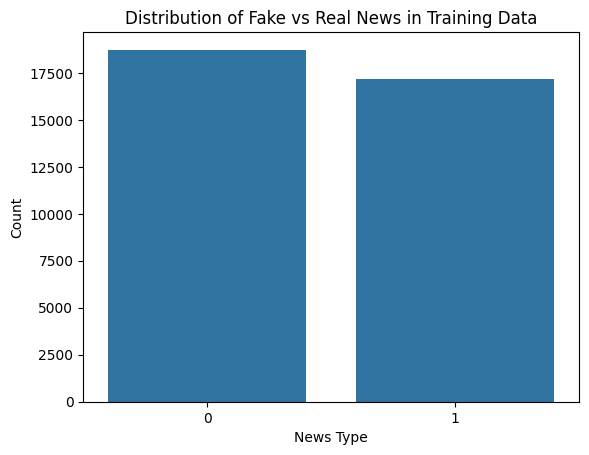

In [73]:
#Ensure distribution of Fake and Real News is not too skewed
sns.countplot(cleaned_train,x='label')
plt.title('Distribution of Fake vs Real News in Training Data')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

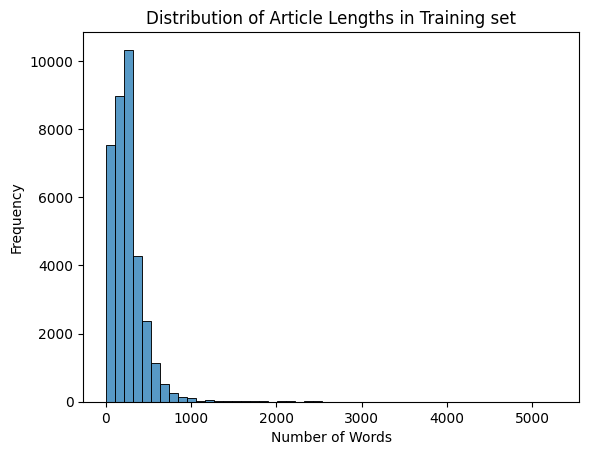

In [75]:
#See distribution of article lengths in training set
cleaned_train["cleaned_text"] =  cleaned_train["cleaned_text"].astype(str)
cleaned_train['text_length']= cleaned_train['cleaned_text'].apply(lambda a : len(a.split()))

sns.histplot(cleaned_train,x='text_length',bins=50)
plt.title("Distribution of Article Lengths in Training set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

Prepare for model testing

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [77]:
# Building a TF IDF matrix
tfidf=TfidfVectorizer(max_features=5000)

# Check for and fill missing values
cleaned_train['cleaned_text'] = cleaned_train['cleaned_text'].fillna('')
cleaned_test['cleaned_text'] = cleaned_test['cleaned_text'].fillna('')

#Train
X_train=tfidf.fit_transform(cleaned_train['cleaned_text'])
y_train=cleaned_train['label']

#Test- use .transform not .fit as model already trained
X_test = tfidf.transform(cleaned_test['cleaned_text'])
y_test = cleaned_test['label']

In [78]:
cleaned_train.head()


,title,text,subject,label,category,dates,cleaned_tokens,cleaned_text,text_length
0,EPA chief says Paris climate agreement 'bad de...,WASHINGTON (Reuters) - The United States shoul...,politicsNews,1,1,2017-04-02,"['washington', 'reuters', 'the', 'united', 'st...",washington reuters the united state continue e...,243
1,BREAKING NEWS: President Trump Announces Major...,President Trump just tweeted out a new policy ...,politics,0,0,2017-07-26,"['president', 'trump', 'tweeted', 'new', 'poli...",president trump tweeted new policy u military ...,69
2,Trump says New Hampshire win not necessary to ...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,1,1,2016-02-07,"['washington', 'reuters', 'u', 's', 'republica...",washington reuters u s republican presidential...,208
3,Kremlin: U.S. sanctions aimed at turning busin...,MOSCOW (Reuters) - The Kremlin said on Thursda...,worldnews,1,1,2017-11-30,"['moscow', 'reuters', 'the', 'kremlin', 'said'...",moscow reuters the kremlin said thursday confi...,52
4,MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...,Kellyanne Conway s response to Williams criti...,left-news,0,0,2016-12-27,"['kellyanne', 'conway', 'response', 'williams'...",kellyanne conway response williams criticism c...,10


In [79]:
#Use LR classifier as this is binary classification
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9869710467706013
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4750
           1       0.98      0.99      0.99      4230

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

